
# Определение перспективного тарифа для телеком-компании

## Описание проекта

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

#### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
    
#### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
#### Примечание
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

### Описание данных

#### Таблицы
Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

#### Примечание
Если объединение таблиц командой merge приводит к ошибке dead kernell, примените join.

## Общая информация

### Библиотеки

Подключим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime

### Таблицы с данными

Подгрузим таблицы с данными от мобильного оператора и получим общее представление о данных

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col = 0)
tariffs = pd.read_csv('/datasets/tariffs.csv')

#### Таблица users(информация о пользователях):

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Тип данных в churn_date и reg_date следует поменять на datetime

In [4]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [6]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [7]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart


In [8]:
users.tail(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
490,1490,30,NaT,Москва,Радомир,Алесин,2018-04-03,smart
491,1491,56,NaT,Челябинск,Радислав,Андрейкин,2018-04-25,ultra
492,1492,63,NaT,Санкт-Петербург,Руслана,Артёменко,2018-06-26,smart
493,1493,71,NaT,Красноярск,Таисия,Ахматулина,2018-11-24,ultra
494,1494,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart
495,1495,65,NaT,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaT,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaT,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart


Большое кол-во NaN значений в churn_date, обусловлено тем, что тариф был еще подключен на момент выгрузки данных. Соответственно, не нужно работать с пропущенными значениями.

#### Таблица сalls(информация о звонках)

In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


call_date - тип данных переведем в datetime

In [10]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [11]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [12]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [13]:
calls.tail(10)

,id,call_date,duration,user_id
202597,1499_210,2018-10-02,8.86,1499
202598,1499_211,2018-12-29,4.58,1499
202599,1499_212,2018-12-30,1.35,1499
202600,1499_213,2018-10-17,10.77,1499
202601,1499_214,2018-12-05,2.42,1499
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499
202606,1499_219,2018-12-14,19.62,1499


Округлим id, duration

In [14]:
calls['id'] = calls['id'].astype('int')
calls['duration'] = calls['duration'].astype('int') 
np.ceil(calls['duration']) #ceil округляет вверх

0          0.0
1          0.0
2          2.0
3         13.0
4          5.0
          ... 
202602     0.0
202603    18.0
202604    10.0
202605     4.0
202606    19.0
Name: duration, Length: 202607, dtype: float64

In [15]:
calls.head(10)

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,2,1000
3,10003,2018-09-21,13,1000
4,10004,2018-12-15,5,1000
5,10005,2018-11-02,0,1000
6,10006,2018-10-18,0,1000
7,10007,2018-08-22,18,1000
8,10008,2018-09-15,18,1000
9,10009,2018-08-15,0,1000


In [16]:
calls.tail(10)

,id,call_date,duration,user_id
202597,1499210,2018-10-02,8,1499
202598,1499211,2018-12-29,4,1499
202599,1499212,2018-12-30,1,1499
202600,1499213,2018-10-17,10,1499
202601,1499214,2018-12-05,2,1499
202602,1499215,2018-12-26,0,1499
202603,1499216,2018-10-18,18,1499
202604,1499217,2018-11-10,10,1499
202605,1499218,2018-10-06,4,1499
202606,1499219,2018-12-14,19,1499


Согласно заданию звонки длительностью 0 - пропущенные. Никаких действий не требуется.

#### Таблица messages(информация о сообщениях)

In [17]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


message_date приведем в datetime

In [18]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [19]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [20]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [21]:
messages.tail(10)

,id,message_date,user_id
123026,1499_174,2018-12-14,1499
123027,1499_175,2018-10-09,1499
123028,1499_176,2018-12-17,1499
123029,1499_177,2018-12-30,1499
123030,1499_178,2018-10-25,1499
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


Округлим id

In [22]:
messages['id'] = messages['id'].astype('int')

In [23]:
messages.head(10)

,id,message_date,user_id
0,10000,2018-06-27,1000
1,10001,2018-10-08,1000
2,10002,2018-08-04,1000
3,10003,2018-06-16,1000
4,10004,2018-12-05,1000
5,10005,2018-06-20,1000
6,10006,2018-11-19,1000
7,10007,2018-10-29,1000
8,10008,2018-06-25,1000
9,10009,2018-12-18,1000


In [24]:
messages.tail(10)

,id,message_date,user_id
123026,1499174,2018-12-14,1499
123027,1499175,2018-10-09,1499
123028,1499176,2018-12-17,1499
123029,1499177,2018-12-30,1499
123030,1499178,2018-10-25,1499
123031,1499179,2018-12-12,1499
123032,1499180,2018-09-28,1499
123033,1499181,2018-09-27,1499
123034,1499182,2018-11-15,1499
123035,1499183,2018-11-16,1499


Никаких действий не требуется.

#### Таблица internet(информация об интернет-сессиях)

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [26]:
internet.drop(internet.columns[[0]], axis = 1)

,mb_used,session_date,user_id
0,112.95,2018-11-25,1000
1,1052.81,2018-09-07,1000
2,1197.26,2018-06-25,1000
3,550.27,2018-08-22,1000
4,302.56,2018-09-24,1000
...,...,...,...
149391,318.90,2018-10-03,1499
149392,490.13,2018-12-14,1499
149393,0.00,2018-10-27,1499
149394,1246.32,2018-11-26,1499


session_date приведем в datetime

In [27]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [28]:
internet['id'] = internet['id'].astype('int')

#### Таблица tariffs(информация о тарифах)

In [29]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [30]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

## Подготовка данных

Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [31]:
calls['month'] = calls['call_date'].dt.month
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,0,1000,7
1,10001,2018-08-17,0,1000,8
2,10002,2018-06-11,2,1000,6
3,10003,2018-09-21,13,1000,9
4,10004,2018-12-15,5,1000,12


In [32]:
user_calls = calls.groupby(['user_id','month'])\
.agg({'duration':'sum', 'id':'count'})\
.reset_index()\
.rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})
user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,5,142,22
1,1000,6,144,43
2,1000,7,299,47
3,1000,8,367,52
4,1000,9,421,58


Количество сделанных звонков и израсходованных минут разговора по месяцам посчитано

### Количество отправленных сообщений по месяцам

In [33]:
messages['month'] = messages['message_date'].dt.month
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,6
1,10001,2018-10-08,1000,10
2,10002,2018-08-04,1000,8
3,10003,2018-06-16,1000,6
4,10004,2018-12-05,1000,12


In [34]:
user_messages = messages.groupby(['user_id','month']).agg({'id':'count'}).reset_index().rename(columns={'id':'messages_total_in_month'})
user_messages.head()

,user_id,month,messages_total_in_month
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Количество сообщений для каждого пользователя посчитано.

### Объем израсходованного интернет-трафика по месяцам

In [35]:
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,10000,112.95,2018-11-25,1000,11
1,10001,1052.81,2018-09-07,1000,9
2,10002,1197.26,2018-06-25,1000,6
3,10003,550.27,2018-08-22,1000,8
4,10004,302.56,2018-09-24,1000,9


In [36]:
user_internet = internet.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index().rename(columns={'mb_used':'mb_total_in_month'})
user_internet.head()

,user_id,month,mb_total_in_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Объем израсходованного интернет-трафика по месяцам посчитан

### Месячная выручка с каждого пользователя

In [37]:
data = user_calls.merge(user_messages, on=['user_id','month'], how='outer')
data.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month
0,1000,5,142.0,22.0,22.0
1,1000,6,144.0,43.0,60.0
2,1000,7,299.0,47.0,75.0
3,1000,8,367.0,52.0,81.0
4,1000,9,421.0,58.0,57.0


In [38]:
data = data.merge(user_internet, on=['user_id','month'], how='outer')
data.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_total_in_month
0,1000,5,142.0,22.0,22.0,2253.49
1,1000,6,144.0,43.0,60.0,23233.77
2,1000,7,299.0,47.0,75.0,14003.64
3,1000,8,367.0,52.0,81.0,14055.93
4,1000,9,421.0,58.0,57.0,14568.91


In [39]:
data = data.merge(users[['user_id','city','tariff']], on='user_id', how = 'outer')
data.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_total_in_month,city,tariff
0,1000,5.0,142.0,22.0,22.0,2253.49,Краснодар,ultra
1,1000,6.0,144.0,43.0,60.0,23233.77,Краснодар,ultra
2,1000,7.0,299.0,47.0,75.0,14003.64,Краснодар,ultra
3,1000,8.0,367.0,52.0,81.0,14055.93,Краснодар,ultra
4,1000,9.0,421.0,58.0,57.0,14568.91,Краснодар,ultra


In [40]:
data = data.merge(tariffs, on='tariff', how='outer')
data.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_total_in_month,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,142.0,22.0,22.0,2253.49,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,144.0,43.0,60.0,23233.77,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,299.0,47.0,75.0,14003.64,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,367.0,52.0,81.0,14055.93,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,421.0,58.0,57.0,14568.91,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [41]:
data.isna().sum()

user_id                      0
month                        2
month_calls_duration        42
calls_total_in_month        42
messages_total_in_month    499
mb_total_in_month           13
city                         0
tariff                       0
messages_included            0
mb_per_month_included        0
minutes_included             0
rub_monthly_fee              0
rub_per_gb                   0
rub_per_message              0
rub_per_minute               0
dtype: int64

In [42]:
data['messages_total_in_month'] = data['messages_total_in_month'].fillna(0)
data['mb_total_in_month'] = data['mb_total_in_month'].fillna(0)
data['month_calls_duration'] = data['month_calls_duration'].fillna(0)
data['calls_total_in_month'] = data['calls_total_in_month'].fillna(0)
data.isna().sum()

user_id                    0
month                      2
month_calls_duration       0
calls_total_in_month       0
messages_total_in_month    0
mb_total_in_month          0
city                       0
tariff                     0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

In [43]:
data['month'] = data['month'].fillna(12.0)

In [44]:
data.isna().sum()

user_id                    0
month                      0
month_calls_duration       0
calls_total_in_month       0
messages_total_in_month    0
mb_total_in_month          0
city                       0
tariff                     0
messages_included          0
mb_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64

In [45]:
data.duplicated().sum()

0

In [46]:
def summa(row):
    messages = np.ceil((row['messages_total_in_month'] - row['messages_included']) * row['rub_per_message'])
    mins = np.ceil((row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute'])
    mbs = (np.ceil((row['mb_total_in_month'] - row['mb_per_month_included'])/1024) * row['rub_per_gb'])
    monthly = (row['rub_monthly_fee'])
    total = 0
    for i in [messages, mins, mbs,monthly]:
        if i > 0:
            total += i
    return total
data.head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_total_in_month,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,142.0,22.0,22.0,2253.49,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6.0,144.0,43.0,60.0,23233.77,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7.0,299.0,47.0,75.0,14003.64,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8.0,367.0,52.0,81.0,14055.93,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9.0,421.0,58.0,57.0,14568.91,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [47]:
data['summa'] = data.apply(lambda x: summa(x), axis=1)
data.sort_values(by='summa').head()

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_total_in_month,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,summa
3215,1371,12.0,0.0,0.0,0.0,0.00,Омск,smart,50,15360,500,550,200,3,3,550.0
2062,1230,9.0,249.0,34.0,10.0,8858.98,Томск,smart,50,15360,500,550,200,3,3,550.0
2059,1229,10.0,73.0,9.0,1.0,1810.49,Москва,smart,50,15360,500,550,200,3,3,550.0
2057,1228,11.0,362.0,63.0,0.0,14706.06,Нижний Новгород,smart,50,15360,500,550,200,3,3,550.0
2055,1228,9.0,382.0,64.0,0.0,11460.21,Нижний Новгород,smart,50,15360,500,550,200,3,3,550.0


In [48]:
data.loc[data['user_id'] == 1002]

,user_id,month,month_calls_duration,calls_total_in_month,messages_total_in_month,mb_total_in_month,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,summa
988,1002,6.0,103.0,15.0,4.0,10856.82,Стерлитамак,smart,50,15360,500,550,200,3,3,550.0
989,1002,7.0,193.0,26.0,11.0,17580.10,Стерлитамак,smart,50,15360,500,550,200,3,3,1150.0
990,1002,8.0,254.0,42.0,13.0,20319.26,Стерлитамак,smart,50,15360,500,550,200,3,3,1550.0
991,1002,9.0,182.0,36.0,4.0,16691.08,Стерлитамак,smart,50,15360,500,550,200,3,3,950.0
992,1002,10.0,188.0,33.0,10.0,13888.25,Стерлитамак,smart,50,15360,500,550,200,3,3,550.0
993,1002,11.0,218.0,32.0,16.0,18587.28,Стерлитамак,smart,50,15360,500,550,200,3,3,1350.0
994,1002,12.0,209.0,33.0,12.0,18113.73,Стерлитамак,smart,50,15360,500,550,200,3,3,1150.0


## Анализ данных

- Опишите поведение клиентов оператора, исходя из выборки.
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитайте среднее количество, дисперсию и стандартное отклонение. 
- Постройте гистограммы. Опишите распределения.

In [49]:
data['summa'].describe()

count    3216.000000
mean     1487.697450
std       788.051713
min       550.000000
25%       696.250000
50%      1550.000000
75%      1950.000000
max      6425.000000
Name: summa, dtype: float64

In [50]:
data['tariff'].value_counts()

smart    2230
ultra     986
Name: tariff, dtype: int64

(0.0, 7000.0)

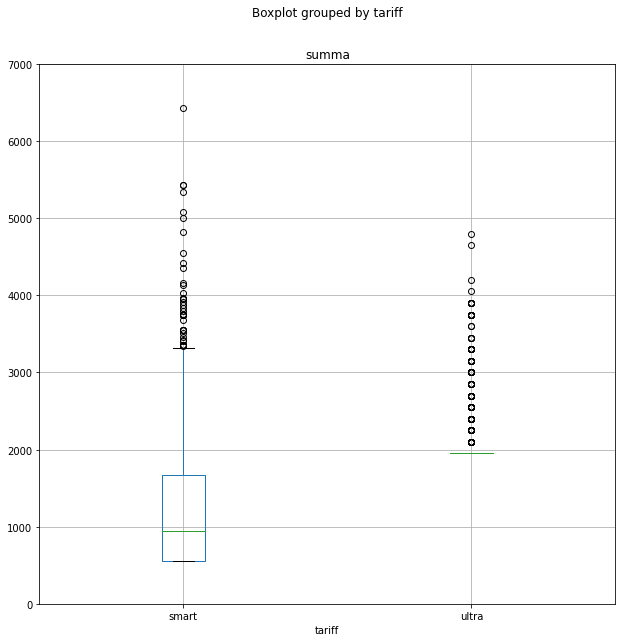

In [51]:
data.boxplot('summa', by='tariff', figsize=(10,10)).set_ylim(0,7000)

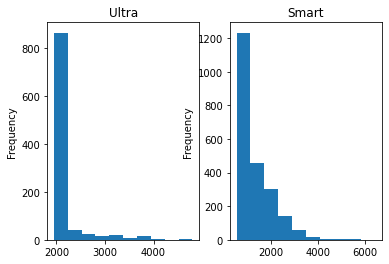

In [52]:
plt.subplot(1,2,1)
data[data['tariff'] == 'ultra']['summa'].plot(kind='hist', bins=10)
plt.title('Ultra');
plt.subplot(1,2,2)
data[data['tariff'] == 'smart']['summa'].plot(kind='hist', bins=10)
plt.title('Smart');

In [53]:
data.groupby('tariff').agg({'summa':['median','mean','var','std']}).style.format("{:.2f}")

In [54]:
data.groupby('tariff').agg({'month_calls_duration':['median','mean','var','std']}).style.format("{:.2f}")

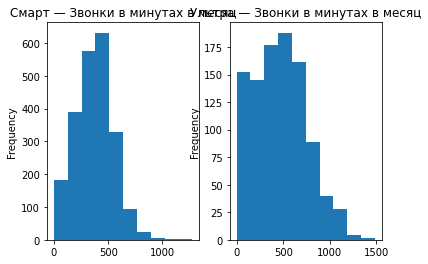

In [55]:
plt.subplot(1,2,1)
data[data['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Смарт — Звонки в минутах в месяц');
plt.subplot(1,2,2)
data[data['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Ультра — Звонки в минутах в месяц');

Пользователи тарифа Смарт превышают предел по звонкам довольно часто, а пользователи Ультра еле-еле доходят до половины.

In [56]:
data.groupby('tariff').agg({'mb_total_in_month':['median','mean','var','std']}).style.format("{:.2f}")

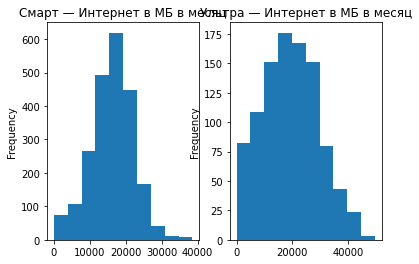

In [57]:
plt.subplot(1,2,1)
data[data['tariff'] == 'smart']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт — Интернет в МБ в месяц');
plt.subplot(1,2,2)
data[data['tariff'] == 'ultra']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра — Интернет в МБ в месяц');

Пользователи тарифа Смарт выходят за лимит по интернету чаще пользователей тарифа Ультра, так как вершина распределения  находится после лимита в 15000, в то время как у Ультра большая часть распределения находится в пределах нормы.

In [58]:
data.groupby('tariff').agg({'messages_total_in_month':['median','mean','var','std']}).style.format("{:.2f}")

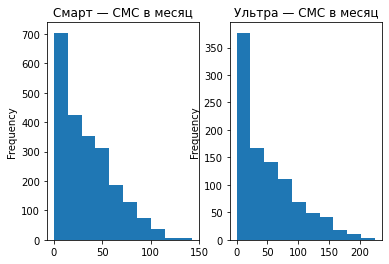

In [59]:
plt.subplot(1,2,1)
data[data['tariff'] == 'smart']['messages_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт — CMC в месяц');
plt.subplot(1,2,2)
data[data['tariff'] == 'ultra']['messages_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра — CMC в месяц');

Пользователи тарифа Смарт постоянно выходят за лимит по СМС, в то время как пользователи Ультра еле-еле набирают пятую часть.

- Опишите поведение клиентов оператора, исходя из выборки.
Если вкратце, то пользователи Смарт практически всегда вынуждены переплачивать, в то время как пользователи Ультра не используют большую часть услуг.
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
Минут: 800 Смарт, 1200 Ультра
Сообщений: 150 Смарт, 200 Ультра
Интернет: 25 Смарт, 40 Ультра
- Посчитайте среднее количество, дисперсию и стандартное отклонение. 
Посчитано при помощи agg
- Постройте гистограммы. Опишите распределения.

## Проверка гипотез

### Гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Функция для удаления выбивающихся значений:

In [60]:
def delete_outliers(data, column, graphic=0, x = 10, y = 10):
    q1 = data[column].quantile(0.25)                 
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (data[column] >= (q1 - 1.5 * iqr)) & (data[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return data.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return data.loc[iqr_test]

<strong>Сформулируем гипотезы:</strong>
<br>
H0:средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается;
<br>
H1:средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

In [61]:
ultra = data[data['tariff'] == 'ultra']
smart = data[data['tariff'] == 'smart']
ultra = ultra['summa']
smart = smart['summa']

In [62]:
alpha = 0.05

In [63]:
results = st.ttest_ind(ultra, smart)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-значение: 3.413402679754156e-195
Отвергаем нулевую гипотезу


<strong>Сформулируем гипотезы:</strong>
<br>
H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
<br>
H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [64]:
data['region'] = np.where(data['city'] == 'Москва', 'Москва', 'Регион')

In [65]:
moscow = data[data['region'] == 'Москва']
region = data[data['region'] == 'Регион']
moscow = moscow['summa']
region = region['summa']

In [66]:
results = st.ttest_ind(moscow, region)

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не можем отвергнуть нулевую гипотезу")

p-значение: 0.44649322481627274
Не можем отвергнуть нулевую гипотезу


### Пояснения
- как вы формулировали нулевую и альтернативную гипотезы
- какой критерий использовали для проверки гипотез и почему

Нулевая гипотеза это утверждение обратное, изначально предложенному и принимаем по умолчанию, пока не будет доказано обратное.
Альтернативная гипотеза в данном задании это предложенная изначально.

Оба случая рассматривают равенство средних двух <strong>независимых</strong> генеральных совокупностей. Поэтому используем критерий Стьюдента.

## Общий вывод

Люди на разных тарифах ведут себя по-разному, что наверно и хорошо. Так и должно работать сегментирование. Но и переплачивают, а это, особенно в Смарте, может приводить к разочарованию и оттоку.

- СМС-ки не особо пользуются популяоностью на тарифе Ультра. Если в Смарте люди близки к максимуму по использованию, то на Ультра люди не пользуются большей частью. Имеет смысл пересмотреть условия тарифа.

- Выручка из регионов и из Москвы не отличается, что заметно из исследования в предыдущем модуле, где 44,6% реузльтатов можно было объяснить случайностью при alpha = 0.05 уровне значимости. Приблизительное равенство выручки можно объяснить тем, что в процентном соотношении жители регионов и мегаполиса Москва пользуются услугами сотового оператора +/- одинаково.

- Альтернативная гипотеза о том, что выручка с тарифов Смарт и Ультра отличается была принята, так как показала низкую погрешность. Разность выручки можно объяснить плохо сбалансироваными тарифными условиями. На первый взгляд тариф Ультра перегружен и люди попросту не могут потратить большую часть доступных услуг.

### Рекомендации
- Оптимизировать тарифы сделать может сделать более низкую цену на Ультра, но в тоже время убрать часть ненужных минут, сообщений и гигабайтов. Дисбаланс тарифов показан в модуле Анализ. В любой ситуации Смарт приносит больше денег. Очень часто пользователи этого тарифа превышают выделенные им услуги и вынужденны переплачивать, чем пользователи тарифа Ультра. В это время, Ультра тариф перенасыщен услугами слишком сильно, пользователи не успевают использовать большую часть из них. Как следствие, они не переплачивают.

### Какой тариф лучше?

По показателю total_paid на графике видно, что пользователи Smart чаще платят больше нежели пользователи Ultra. Сама переплата на тарифе Smart в 3 раза больше, чем на Ultra, поэтому выгодней для оператора будет рекламировать Smart.